# Santander Value Prediction Challenge

In this competition, Santander Group is asking us to help them identify the value of transactions for each potential customer.
We are provided with an anonymized dataset containing numeric feature variables, the numeric target column, and a string ID column. Our task is to predict the value of target column in the test set.

The evaluation metric for this competition is Root Mean Squared Logarithmic Error. The data set consists of train.csv and test.csv

<img src="https://dynl.mktgcdn.com/p/OioPDkijUSBehXPo5nCC_CEd-0hZkZRv94-HHnJj-eA/2326x832.jpg" width=600/>

## Load Libraries

In [1]:
### Import required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# Read train and test files
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

## Data Summary

In [3]:
# training set
print ("Training set:")
n_data  = len(train_df)
n_features = train_df.shape[1]
print ("Number of Records: {}".format(n_data))
print ("Number of Features: {}".format(n_features))

# testing set
print ("\nTesting set:")
n_data  = len(test_df)
n_features = test_df.shape[1]
print ("Number of Records: {}".format(n_data))
print ("Number of Features: {}".format(n_features))

Training set:
Number of Records: 4459
Number of Features: 4993

Testing set:
Number of Records: 49342
Number of Features: 4992


We have more features than records in the Training set.

- We have a total of `4993` features in the `Train` set.
- The number of records in `Train` set is just `4459`


- We have a total of `4992` features in the `Test` set.
- The number of records in `Test` set is just `49342`

### Train Data

In [4]:
train_df.head(n=10)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,1300000.0,...,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.0,0.0,0,0.0,0,0,0,0,0,17020000.0,0.0,8000.0,0,0,0,0,0.0,0,5000000.0,0,0,0.0,0,0,0.0,0,0,0,12000.0,0,4600.0,12000,8891333.34,0.0,0,0.0,0,0,0.0,...,12000,0,0.0,0,0,0,0.0,0.0,0,0.0,20000000.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,40000,0,0,0
7,003eb0261,600000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
8,004b92275,979000.0,0.0,0,0.0,0,0,0,0,0,58000.0,0.0,0.0,0,0,22000,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,4000000.0,0.0,16000.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,22000,0.0,0.0,0.0,4000000.0,0,0,0,0,0,0,0
9,0067b4fef,460000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,400000


### Train Data Info

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


So there are a total of 4993 features out of which 1845 are of type float64, 3147 are int64 and 1 is object (ID is the object column).

The sad thing is that, as mentioned earier, we do not have meaningful names for the features. So, we have to rely on other ways to analyze and understand the data.

### Test Data

In [6]:
test_df.head(n=10)

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.528249e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,20884000.0,0.0,0.0,0.0,0.0,0.0,36252000.0,0.0,20000000.0,0.0,...,0.0,0.0,25010000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0005fc190,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,000787e86,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0008510a0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,000895faf,0.0,0.0,2.461712e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276673.667565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Test Data Info

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


So there are a total of 4992 features in the test set out of which 4991 are of type float64 and 1 is object (ID is the object column)

## Check for Missing Values

In [8]:
#### Check if there are any NULL values in Train Data
print("Total Train Features with NaN Values = " + str(train_df.columns[train_df.isnull().sum() != 0].size))
if (train_df.columns[train_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train_df.columns[train_df.isnull().sum() != 0])))
    train_df[train_df.columns[train_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Train Features with NaN Values = 0


In [9]:
#### Check if there are any NULL values in Test Data
print("Total Test Features with NaN Values = " + str(test_df.columns[test_df.isnull().sum() != 0].size))
if (test_df.columns[test_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test_df.columns[test_df.isnull().sum() != 0])))
    test_df[test_df.columns[test_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Test Features with NaN Values = 0


We are lucky enough to get some data that has got no `NULLS`. So, we can go ahead and start anaylzing the data.

## Prepare the Data

In [10]:
X_train = train_df.drop(["ID", "target"], axis=1)
y_train = np.log1p(train_df["target"].values)

X_test = test_df.drop(["ID"], axis=1)

## Check and Remove Constant Features

As we have lot of features, we will look for ways to trim down on the number of features. From the above sample records we can see that many of the records and features contains **`0`**. Also as there are many features, we will try to see if there are any features with constant values.

In [11]:
# check and remove constant columns
colsToRemove = []
for col in X_train.columns:
    if X_train[col].std() == 0: 
        colsToRemove.append(col)
        
# remove constant columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
X_test.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `256` Constant Columns

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a7

## Check and Remove Duplicate Columns

In [12]:
# Check and remove duplicate columns
colsToRemove = []
colsScaned = []
dupList = {}

columns = X_train.columns

for i in range(len(columns)-1):
    v = X_train[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, X_train[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
                
# remove duplicate columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True) 

# remove duplicate columns in the testing set
X_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(dupList)))
print(dupList)

Removed `4` Duplicate Columns

{'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}


In [13]:
print("Train set size: {}".format(X_train.shape))
print("Test set size: {}".format(X_test.shape))

Train set size: (4459, 4730)
Test set size: (49342, 4730)


## Exploratory Data Analysis

As we have `4730 features` it would be very difficult to visualize and analyze all of them. So, we will try to analyze only some of the top features.

### Feature Importance from GradientBoostingRegressor

Below, we will use the GradientBoostingRegressor to see the top features in our dataset.

In [14]:
# Find feature importance
clf_gb = GradientBoostingRegressor(random_state = 42)
clf_gb.fit(X_train, y_train)
print(clf_gb)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


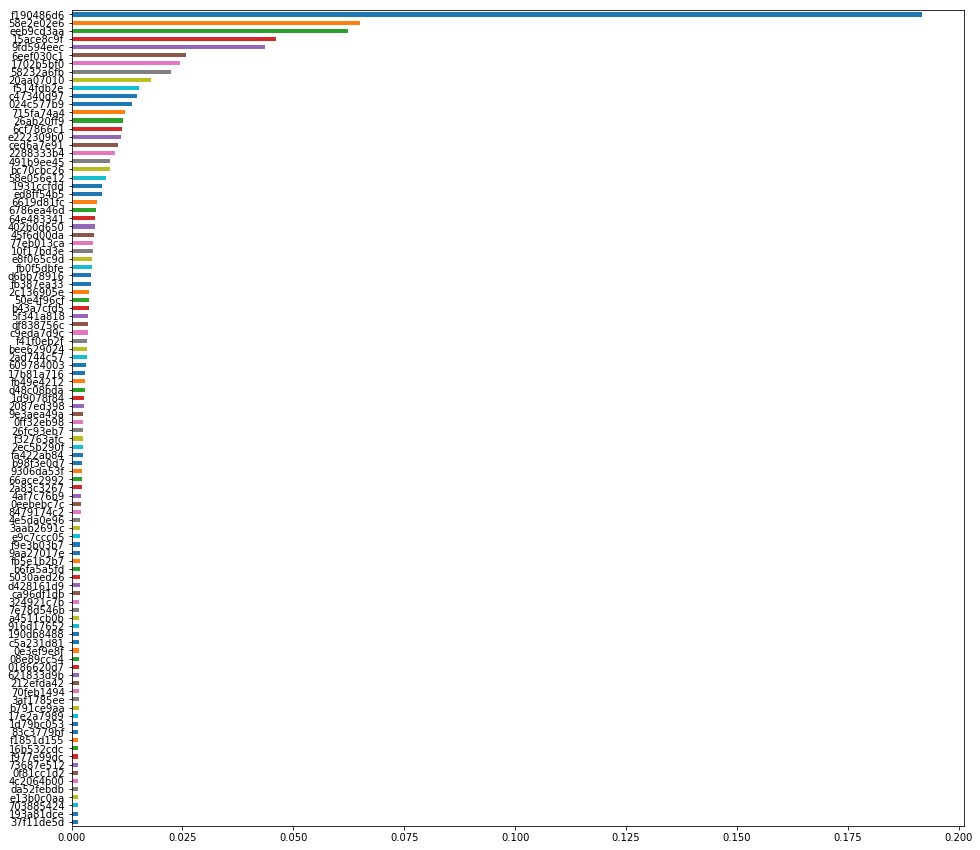

In [15]:
# GradientBoostingRegressor feature importance - top 100
feat_importances = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(100)
plt.figure(figsize=(16,15))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

The above plot looks very cluttered. Instead, we will take a look at the `top 25 features`.

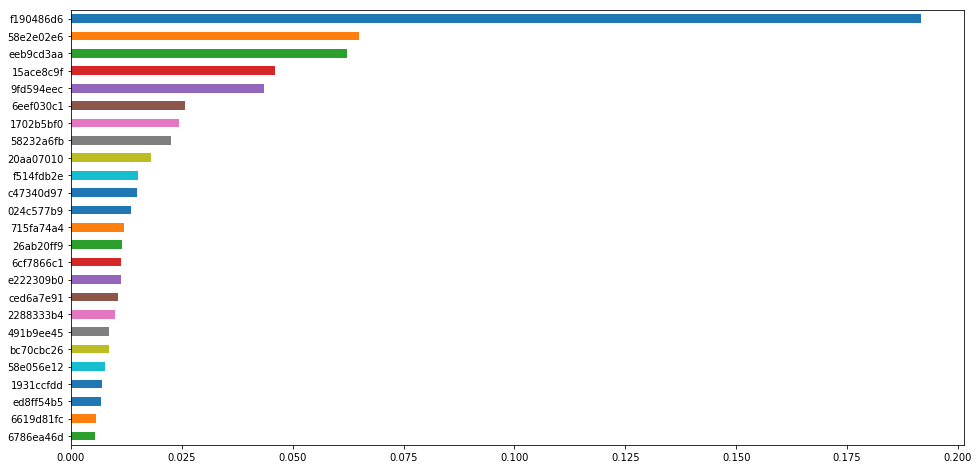

In [16]:
# GradientBoostingRegressor feature importance - top 25
feat_importances_gb = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances_gb = feat_importances_gb.nlargest(25)
plt.figure(figsize=(16,8))
feat_importances_gb.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

Below we will list the `top 10 features` with their feature importances.

In [17]:
print(pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.191684
58e2e02e6    0.064993
eeb9cd3aa    0.062291
15ace8c9f    0.046012
9fd594eec    0.043513
6eef030c1    0.025690
1702b5bf0    0.024469
58232a6fb    0.022472
20aa07010    0.017970
f514fdb2e    0.015200
dtype: float64


### Feature Importance from RandomForestRegressor

In [18]:
# Find feature importance
clf_rf = RandomForestRegressor(random_state = 42)
clf_rf.fit(X_train, y_train)
print(clf_rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


We will plot the top 25 features from RandomForestRegressor to see how similar they are with the top features given by GradientBoostingRegressor.

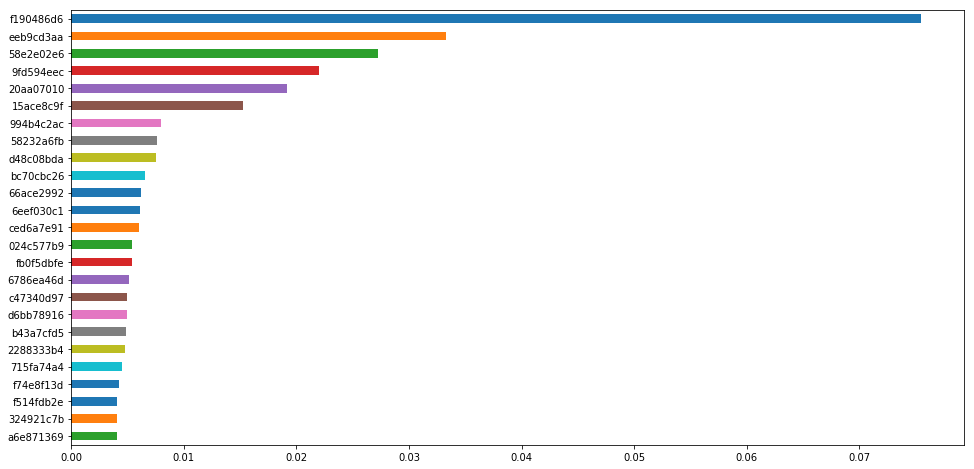

In [19]:
# RandomForestRegressor feature importance - top 25
feat_importances_rf = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
feat_importances_rf = feat_importances_rf.nlargest(25)
plt.figure(figsize=(16,8))
feat_importances_rf.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

In [20]:
print(pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.075523
eeb9cd3aa    0.033265
58e2e02e6    0.027267
9fd594eec    0.021992
20aa07010    0.019176
15ace8c9f    0.015254
994b4c2ac    0.007953
58232a6fb    0.007641
d48c08bda    0.007545
bc70cbc26    0.006561
dtype: float64


### GradientBoostingRegressor vs RandomForestRegressor Top 25 Features

<Figure size 432x288 with 0 Axes>

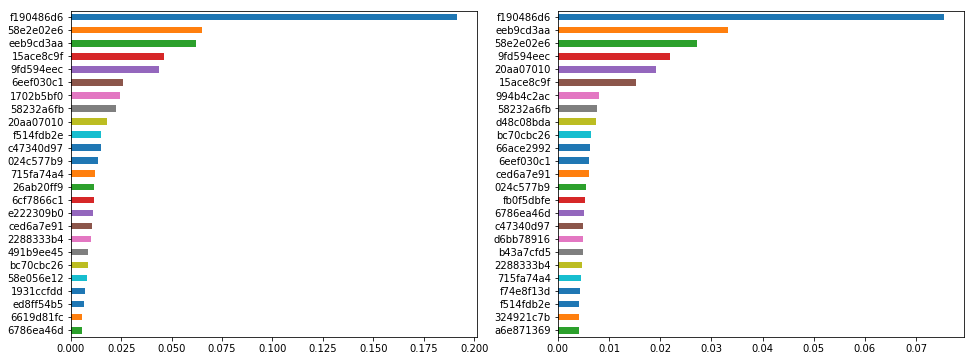

In [21]:
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(16,6))
feat_importances_gb.plot(kind='barh', ax=ax[0])
feat_importances_rf.plot(kind='barh', ax=ax[1])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

In [22]:
s1 = pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10).index
s2 = pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(10).index

common_features = pd.Series(list(set(s1).intersection(set(s2)))).values

print(common_features)

['20aa07010' 'eeb9cd3aa' '9fd594eec' '58e2e02e6' '15ace8c9f' 'f190486d6'
 '58232a6fb']


So, we can see that there are a total of just 6 common features in top 25 features of RandomForestRegressor and GradientBoostingRegressor. So, we should be careful in choosing what feature sto pick for further analysis.

## Data Visualization

Below we will see some visualizations related to the top features.

Text(0.5, 0.98, 'Pairplot of Top 6 Important Features')

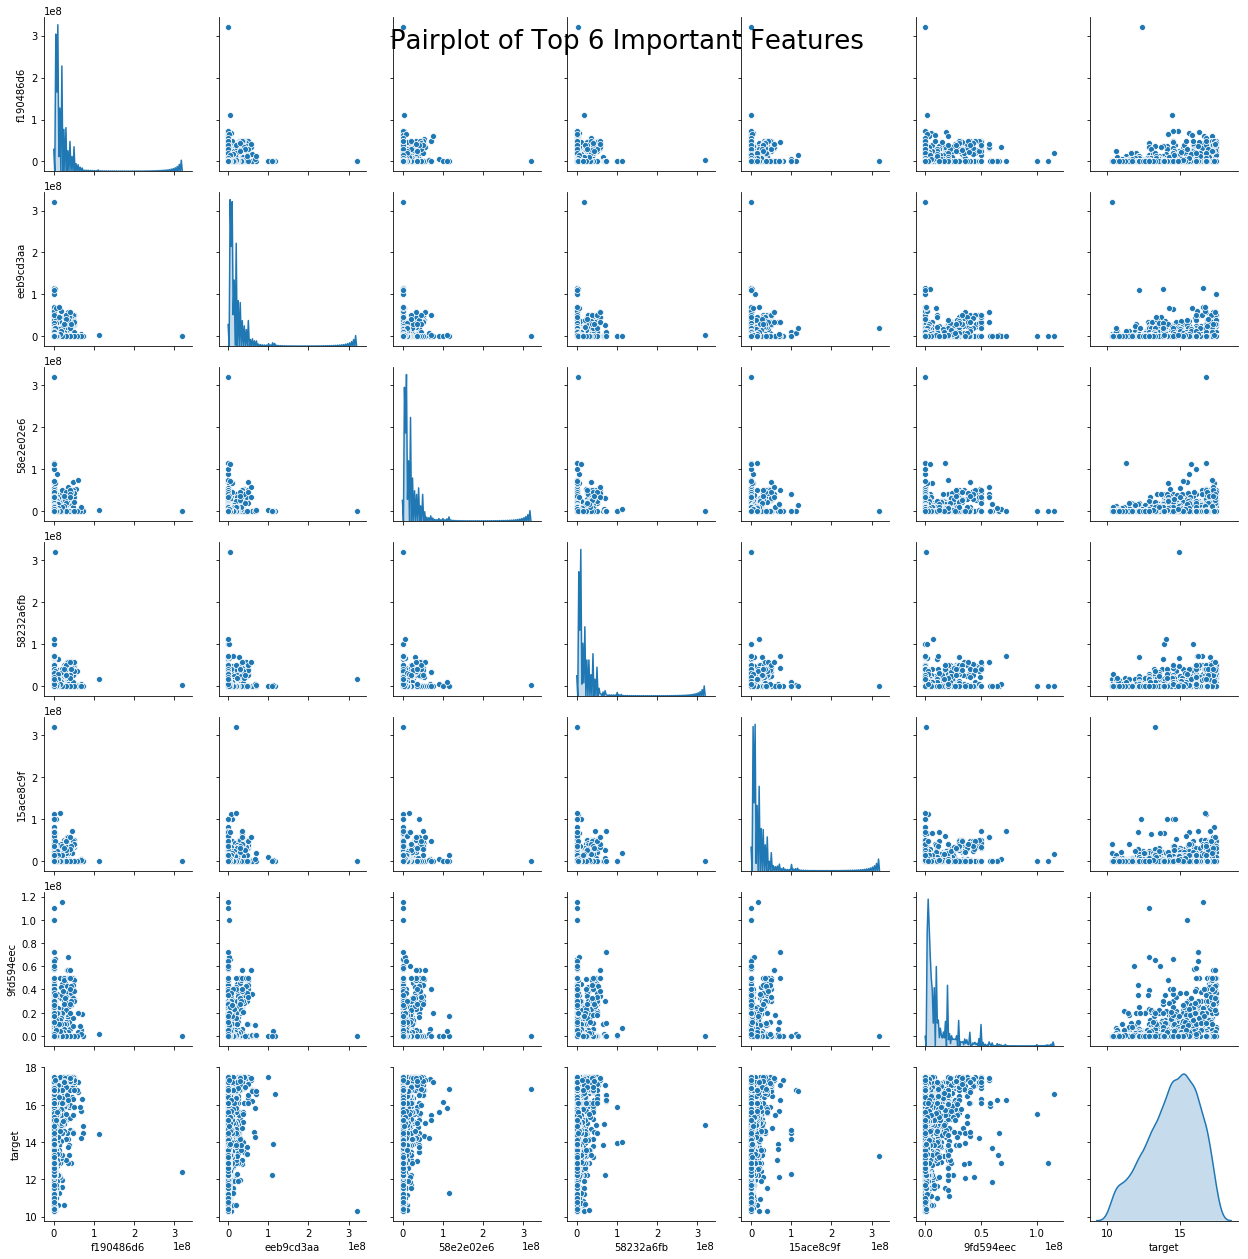

In [23]:
df_plot = X_train[['f190486d6', 'eeb9cd3aa', '58e2e02e6', '58232a6fb', '15ace8c9f', '9fd594eec']]
df_plot['target'] = y_train

g = sns.pairplot(df_plot, diag_kind="kde", palette="BuGn_r")
g.fig.suptitle('Pairplot of Top 6 Important Features',fontsize=26)

## Correlation HeatMap

In [24]:
# PLot Correlation HeatMap for top 20 features from GB and RF Models
s1 = pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(20).index
s2 = pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(20).index

common_features = pd.Series(list(set(s1).union(set(s2)))).values

print(common_features)

['f514fdb2e' '2288333b4' '715fa74a4' '1702b5bf0' '26ab20ff9' 'c47340d97'
 '9fd594eec' 'ced6a7e91' '491b9ee45' 'f190486d6' '58232a6fb' '6786ea46d'
 '024c577b9' 'd48c08bda' 'fb0f5dbfe' '6eef030c1' '20aa07010' 'eeb9cd3aa'
 'bc70cbc26' 'd6bb78916' '994b4c2ac' 'e222309b0' '6cf7866c1' '58e2e02e6'
 '15ace8c9f' '66ace2992' 'b43a7cfd5']


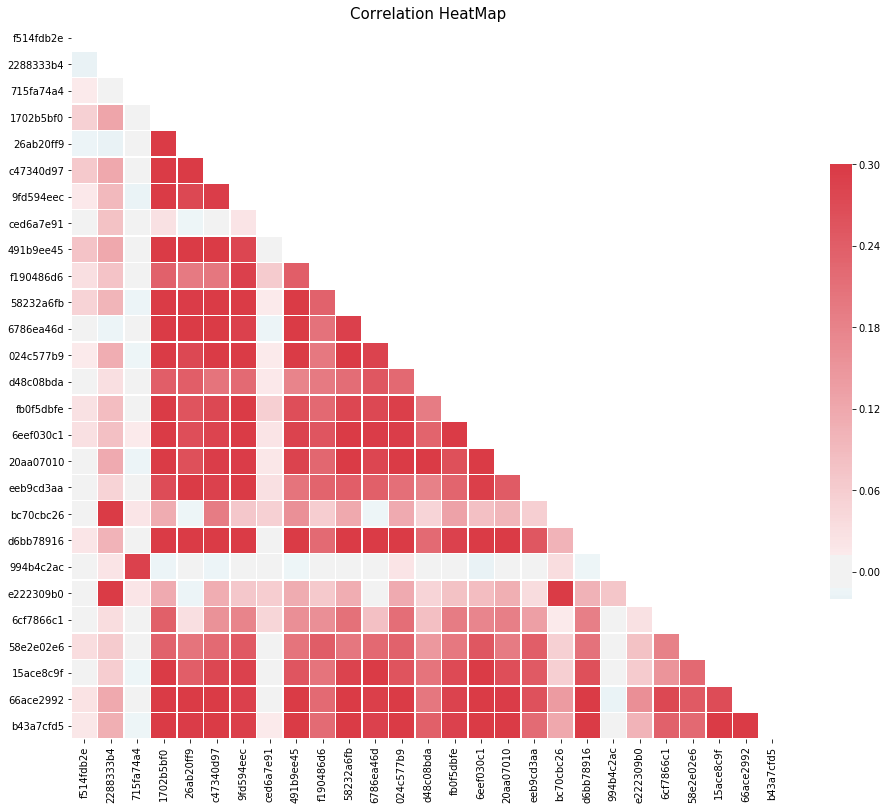

In [25]:
df_plot = pd.DataFrame(X_train, columns = common_features)
corr = df_plot.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation HeatMap", fontsize=15)
plt.show()

## PCA Visualization

In [26]:
X_train_cpy = X_train.copy()
pca = PCA(n_components=3)
X_train_cpy = pca.fit_transform(X_train_cpy)

In [27]:
print(pca.components_)

[[-3.60395141e-05 -3.25225460e-06  2.97042527e-05 ... -6.66545307e-04
   1.14721715e-03  4.07998884e-03]
 [ 1.88297425e-06 -2.12946104e-07 -4.87056149e-06 ... -4.46188839e-05
   6.19895704e-05  1.05838187e-04]
 [-1.35106815e-06 -1.26796781e-07 -2.68958448e-06 ... -5.36994903e-05
   6.42533887e-05  5.31590303e-05]]


In [28]:
print(pca.explained_variance_)

[7.47289112e+15 4.87637112e+15 4.87436029e+15]


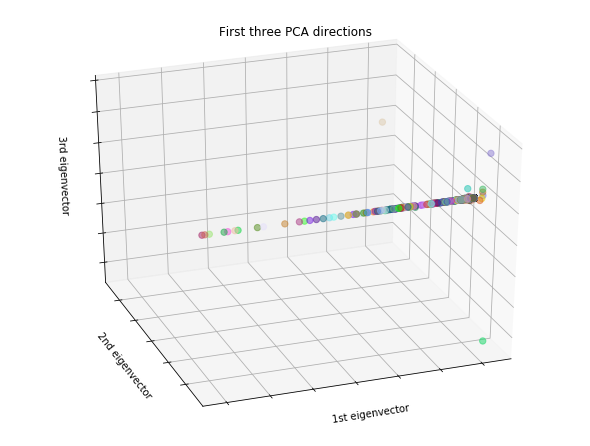

In [29]:
colors = np.random.random((4459, 3))

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_train_cpy[:, 0], X_train_cpy[:, 1], X_train_cpy[:, 2], c=colors,
           cmap=plt.cm.Set1, edgecolor=colors, alpha=0.5, s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

## Modeling

In [30]:
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

### LightGBM

In [31]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [32]:
# Training LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.61862
[100]	valid_0's rmse: 1.55904
[150]	valid_0's rmse: 1.51633
[200]	valid_0's rmse: 1.48392
[250]	valid_0's rmse: 1.46091
[300]	valid_0's rmse: 1.444
[350]	valid_0's rmse: 1.43346
[400]	valid_0's rmse: 1.42565
[450]	valid_0's rmse: 1.42068
[500]	valid_0's rmse: 1.41726
[550]	valid_0's rmse: 1.41394
[600]	valid_0's rmse: 1.41119
[650]	valid_0's rmse: 1.40985
[700]	valid_0's rmse: 1.40957
[750]	valid_0's rmse: 1.40933
Early stopping, best iteration is:
[687]	valid_0's rmse: 1.40919
LightGBM Training Completed...


In [33]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:15])

Features Importance...
        feature  split      gain
4131  f190486d6    586  7.976637
2378  58e2e02e6    554  5.120466
3467  eeb9cd3aa    506  4.789270
4021  15ace8c9f    439  3.331270
2616  9fd594eec    259  3.111541
8     20aa07010    316  2.185156
834   6eef030c1    257  1.549627
3572  58232a6fb    283  1.401872
1459  b43a7cfd5    293  1.212928
3662  491b9ee45    236  1.134372
2689  fb0f5dbfe    321  1.127745
1484  024c577b9    211  1.079821
4344  1702b5bf0    212  0.854425
3868  2288333b4    120  0.853516
3223  ced6a7e91    210  0.850369


In [34]:
sub = pd.read_csv('../input/sample_submission.csv')
sub["target"] = pred_test
print(sub.head())
sub.to_csv('sub_lgb.csv', index=False)

          ID        target
0  000137c73  1.890963e+06
1  00021489f  1.784841e+06
2  0004d7953  2.605519e+06
3  00056a333  5.428303e+06
4  00056d8eb  1.988727e+06
